In [7]:
import os
import sys
import inspect
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import warnings
import itertools
import joblib
import sklearn

from datetime import date, timedelta
from matplotlib import style

from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import f1_score, confusion_matrix, roc_curve, auc, accuracy_score, log_loss, balanced_accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import SelectFromModel

from xgboost import XGBClassifier

from ta import add_all_ta_features

from helpers import Featurizer, normalize_price, plot_confusion_matrix

warnings.simplefilter("ignore")
style.use('ggplot')

security = '^IBEX'

In [19]:
today = date(2019, 11, 23) # date.today() + timedelta(days=1) # date(2019, 11, 22) #
start_date = '2001-07-01' # today - timedelta(days=150) # 
today

datetime.date(2019, 11, 23)

In [20]:
ticker = yf.Ticker(security)
df = ticker.history(start=start_date, end=today.strftime('%Y-%m-%d'), interval='1d')
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2001-07-02,8878.391790,9083.991201,8827.691644,9073.291016,88000,0,0
2001-07-03,9073.290960,9104.891515,8954.691466,9015.891602,93600,0,0
2001-07-04,8994.191298,8994.191298,8850.891635,8884.991211,70400,0,0
2001-07-05,8884.991114,8893.691300,8761.491237,8787.590820,84200,0,0
2001-07-06,8738.790771,8738.790771,8456.391649,8501.891602,146400,0,0
...,...,...,...,...,...,...,...
2019-11-18,9265.099609,9293.099609,9213.000000,9258.000000,135267700,0,0
2019-11-19,9288.000000,9327.500000,9234.400391,9259.200195,121796100,0,0
2019-11-20,9223.700195,9240.400391,9165.400391,9225.400391,139899200,0,0


In [21]:
df['2010-08-22':'2010-08-31']['Volume'].mean()

143721142.85714287

In [22]:
alpha = df['2010-08-22':'2010-08-31']['Volume'].mean()/df[:'2010-08-22']['Volume'].mean()
alpha

817.6859496335845

In [23]:
# Desechamos los datos previos al 1 de julio de 2001
df = df['2001-07-01':]

# Alteramos la proporción del volumen de negociación
mask = (df.index >= '2001-07-01') & (df.index < '2010-08-22')
df['Volume'].mask(mask, df['Volume'] * alpha, inplace=True)
df['Volume'].replace(0, np.nan, inplace=True)
df['Volume'].interpolate(method='linear', inplace=True)

Text(0, 0.5, 'Volumen')

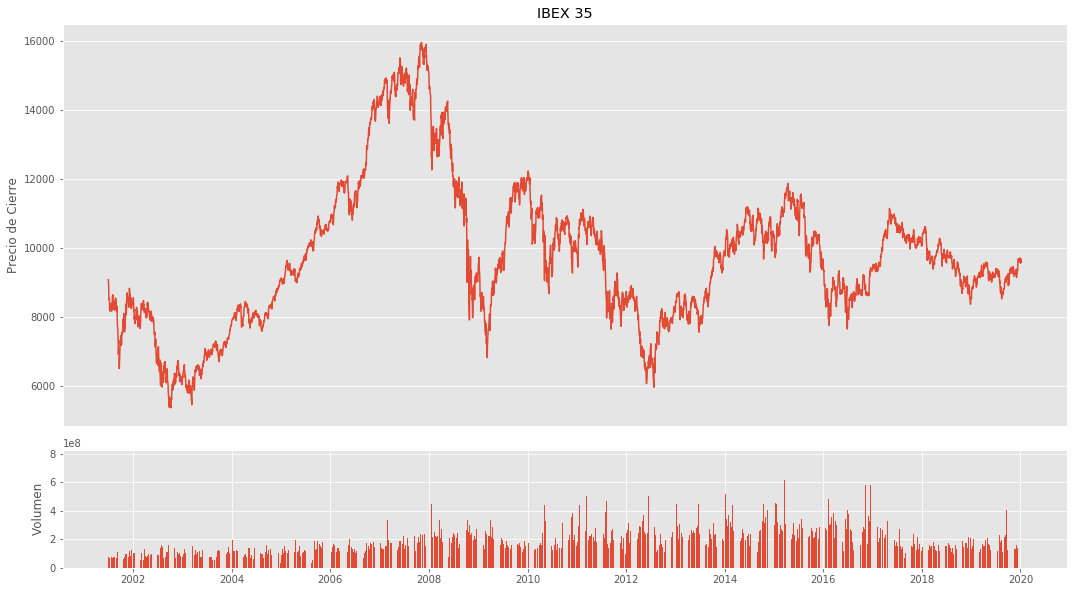

In [7]:
# Visualizamos los datos para ver cómo quedan
plt.figure(figsize=(18,10))
top = plt.subplot2grid((4,4), (0, 0), rowspan=3, colspan=4)
bottom = plt.subplot2grid((4,4), (3,0), rowspan=1, colspan=4)
top.plot(df.index, df['Close'])
bottom.bar(df.index, df['Volume']) 

top.axes.get_xaxis().set_visible(False)
top.set_title('IBEX 35')
top.set_ylabel('Precio de Cierre')
bottom.set_ylabel('Volumen')

In [24]:
ts = df[:-30]

In [25]:
ts

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2001-07-02,8878.391790,9083.991201,8827.691644,9073.291016,7.195636e+07,0,0
2001-07-03,9073.290960,9104.891515,8954.691466,9015.891602,7.653540e+07,0,0
2001-07-04,8994.191298,8994.191298,8850.891635,8884.991211,5.756509e+07,0,0
2001-07-05,8884.991114,8893.691300,8761.491237,8787.590820,6.884916e+07,0,0
2001-07-06,8738.790771,8738.790771,8456.391649,8501.891602,1.197092e+08,0,0
...,...,...,...,...,...,...,...
2019-10-07,8954.700195,9046.299805,8930.400391,9044.099609,1.310803e+08,0,0
2019-10-08,9066.500000,9071.500000,8900.799805,8940.099609,1.403706e+08,0,0
2019-10-09,8952.700195,9035.599609,8934.200195,8991.900391,1.036380e+08,0,0


In [26]:
featurizer = Featurizer(ts)
featurizer.add_features(forecast_horizon=5, with_ndays_lag=0)

In [27]:
X_train, y_train, X_test, y_test = featurizer.crossval_split(split_session=30, predict_day=1)

In [31]:
featurizer.df[['Open', 'High', 'Low', 'Close', 'PREDICTOR_0dayAhead', 'PREDICTOR_1dayAhead']].tail()

,Open,High,Low,Close,PREDICTOR_0dayAhead,PREDICTOR_1dayAhead
Date,,,,,,
2019-10-07,8954.700195,9046.299805,8930.400391,9044.099609,1,-1.0
2019-10-08,9066.500000,9071.500000,8900.799805,8940.099609,-1,1.0
2019-10-09,8952.700195,9035.599609,8934.200195,8991.900391,1,1.0
2019-10-10,8997.400391,9112.200195,8970.299805,9104.400391,1,1.0
2019-10-11,9112.900391,9273.799805,9104.799805,9273.799805,1,NaN


In [29]:
X_train.shape

(4615, 86)

In [32]:
X_test.shape

(30, 86)

In [33]:
tscv = featurizer.timeseries_cross_validator(X_train.shape[0], test_size=X_test.shape[0])

In [34]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)

y_hat = xgb.predict(X_test)

f1 = f1_score(y_pred=y_hat, y_true=y_test)
accuracy = accuracy_score(y_pred=y_hat, y_true=y_test)
baccuracy = balanced_accuracy_score(y_pred=y_hat, y_true=y_test)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("Balanced Accuracy: %.2f%%" % (baccuracy * 100.0))
print("F1 Score: %.2f%%" % (f1 * 100.0))

Accuracy: 53.33%
Balanced Accuracy: 57.42%
F1 Score: 53.33%


In [35]:
pd.DataFrame(
    confusion_matrix(y_pred=y_hat, y_true=y_test),
    columns=['Predicted Sell', 'Predicted Buy'],
    index=['True Sell', 'True Buy']
)

,Predicted Sell,Predicted Buy
True Sell,8,3
True Buy,11,8


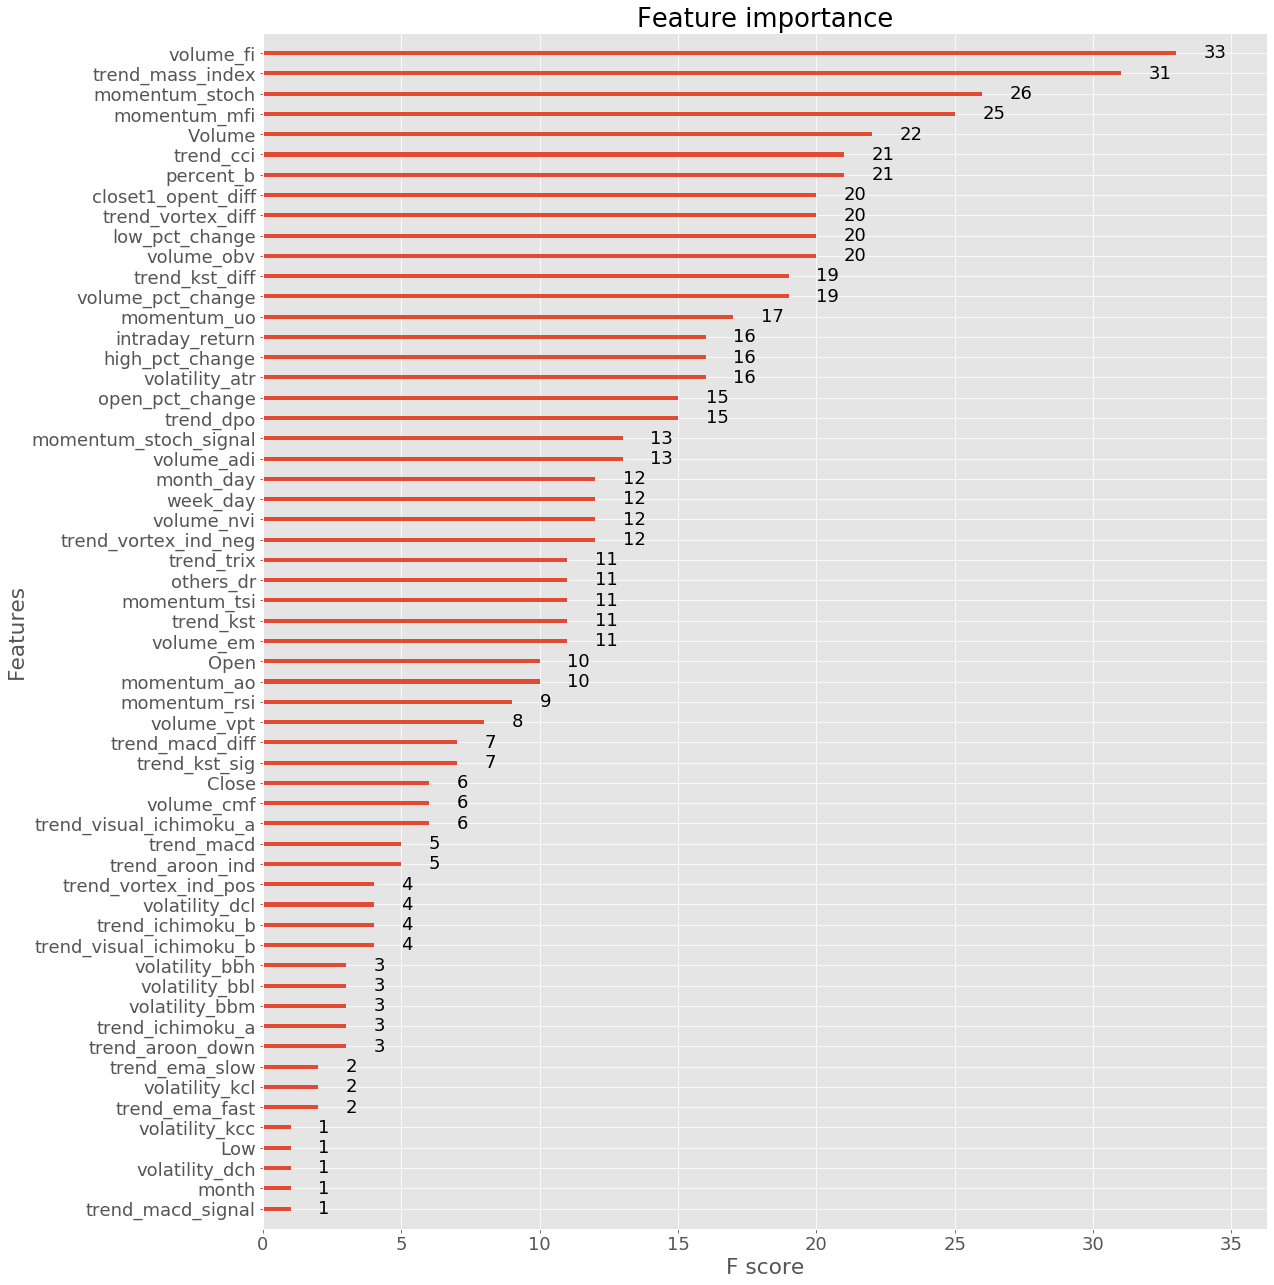

In [43]:
from xgboost import plot_importance

plt.rcParams["figure.figsize"] = (18,22)
plt.rcParams['font.size'] = 18
plot_importance(xgb)
plt.show()

In [15]:
from numpy import sort

best_threshold = 0
last_accuracy = 0
last_f1score = 0
last_logloss = np.inf
thresholds = sort(xgb.feature_importances_)
for thresh in thresholds:
    if thresh > 0:
        # select features using threshold
        selection = SelectFromModel(xgb, threshold=thresh, prefit=True)
        select_X_train = selection.transform(X_train)
        # train model
        selection_model = XGBClassifier(random_state=5)
        selection_model.fit(select_X_train, y_train)
        # eval model
        select_X_test = selection.transform(X_test)
        predictions = selection_model.predict(select_X_test)
        accuracy = accuracy_score(y_test, predictions)
        baccuracy = balanced_accuracy_score(y_test, predictions)
        logloss = log_loss(y_test, predictions)
        f1score = f1_score(y_test, predictions)

        print("Thresh=%.10f, n=%d, Accuracy: %.2f%%, Balanced Acc.: %.2f%%, Log loss: %.5f, F1: %.2f%%." % (
          thresh, select_X_train.shape[1], accuracy*100.0, baccuracy*100, logloss, f1score*100.0
        ))

        if logloss <= last_logloss:
            last_logloss = logloss
            last_accuracy = accuracy
            last_f1score = f1score
            best_threshold = thresh

Thresh=0.0062890700, n=59, Accuracy: 46.67%, Balanced Acc.: 44.64%, Log loss: 18.42079, F1: 20.00%.
Thresh=0.0078523802, n=58, Accuracy: 46.67%, Balanced Acc.: 44.64%, Log loss: 18.42079, F1: 20.00%.
Thresh=0.0089688888, n=57, Accuracy: 46.67%, Balanced Acc.: 44.64%, Log loss: 18.42079, F1: 20.00%.
Thresh=0.0106895939, n=56, Accuracy: 53.33%, Balanced Acc.: 50.89%, Log loss: 16.11815, F1: 22.22%.
Thresh=0.0115371970, n=55, Accuracy: 53.33%, Balanced Acc.: 50.89%, Log loss: 16.11815, F1: 22.22%.
Thresh=0.0116645964, n=54, Accuracy: 50.00%, Balanced Acc.: 47.77%, Log loss: 17.26947, F1: 21.05%.
Thresh=0.0122615062, n=53, Accuracy: 56.67%, Balanced Acc.: 54.91%, Log loss: 14.96688, F1: 38.10%.
Thresh=0.0122819832, n=52, Accuracy: 50.00%, Balanced Acc.: 48.21%, Log loss: 17.26949, F1: 28.57%.
Thresh=0.0127869453, n=51, Accuracy: 50.00%, Balanced Acc.: 47.77%, Log loss: 17.26947, F1: 21.05%.
Thresh=0.0129685784, n=50, Accuracy: 53.33%, Balanced Acc.: 51.34%, Log loss: 16.11818, F1: 30.00%.


In [16]:
best_threshold

0.021873273

In [17]:
thresh=best_threshold

selection = SelectFromModel(xgb, threshold=thresh, prefit=True)
X_train_thresh = selection.transform(X_train)
X_test_thresh = selection.transform(X_test)

In [18]:
params = {
    'n_estimators': 100,
    'max_depth': 6,
    'learning_rate': 0.1,
    'colsample_bytree': 1,
    'colsample_bylevel': 1,
    'colsample_bynode': 0.5,
    'random_state': 5
}

extra_model = XGBClassifier(**params)

In [19]:
eval_set = [(X_test_thresh, y_test)]

extra_model.fit(
    X_train_thresh, y_train, 
    eval_metric="auc", 
    eval_set=eval_set, 
    verbose=True
)
y_hat = extra_model.predict(X_test_thresh)

f1 = f1_score(y_pred=y_hat, y_true=y_test)
accuracy = accuracy_score(y_pred=y_hat, y_true=y_test)
baccuracy = balanced_accuracy_score(y_pred=y_hat, y_true=y_test)
lloss = log_loss(y_pred=y_hat, y_true=y_test)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("Balanced Accuracy: %.2f%%" % (baccuracy * 100.0))
print("F1 Score: %.2f%%" % (f1 * 100.0))
print("Log loss: %.2f" % lloss)

[0]	validation_0-auc:0.589286
[1]	validation_0-auc:0.607143
[2]	validation_0-auc:0.636161
[3]	validation_0-auc:0.636161
[4]	validation_0-auc:0.640625
[5]	validation_0-auc:0.658482
[6]	validation_0-auc:0.671875
[7]	validation_0-auc:0.671875
[8]	validation_0-auc:0.671875
[9]	validation_0-auc:0.654018
[10]	validation_0-auc:0.649554
[11]	validation_0-auc:0.575893
[12]	validation_0-auc:0.569196
[13]	validation_0-auc:0.569196
[14]	validation_0-auc:0.587054
[15]	validation_0-auc:0.591518
[16]	validation_0-auc:0.595982
[17]	validation_0-auc:0.595982
[18]	validation_0-auc:0.587054
[19]	validation_0-auc:0.587054
[20]	validation_0-auc:0.573661
[21]	validation_0-auc:0.595982
[22]	validation_0-auc:0.627232
[23]	validation_0-auc:0.631696
[24]	validation_0-auc:0.627232
[25]	validation_0-auc:0.558036
[26]	validation_0-auc:0.558036
[27]	validation_0-auc:0.589286
[28]	validation_0-auc:0.629464
[29]	validation_0-auc:0.629464
[30]	validation_0-auc:0.629464
[31]	validation_0-auc:0.629464
[32]	validation_0-

[0]	validation_0-auc:0.560027	validation_0-error:0.443392	validation_0-logloss:0.690986	validation_1-auc:0.589286	validation_1-error:0.533333	validation_1-logloss:0.693192
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 10 rounds.
[1]	validation_0-auc:0.629413	validation_0-error:0.408308	validation_0-logloss:0.686542	validation_1-auc:0.607143	validation_1-error:0.466667	validation_1-logloss:0.691843
[2]	validation_0-auc:0.654736	validation_0-error:0.397331	validation_0-logloss:0.682952	validation_1-auc:0.636161	validation_1-error:0.5	validation_1-logloss:0.691286
[3]	validation_0-auc:0.660696	validation_0-error:0.399699	validation_0-logloss:0.681255	validation_1-auc:0.636161	validation_1-error:0.5	validation_1-logloss:0.691596
[4]	validation_0-auc:0.679916	validation_0-error:0.379251	validation_0-logloss:0.67859	validation_1-auc:0.640625	validation_1-error:0.466667	validation_1-log

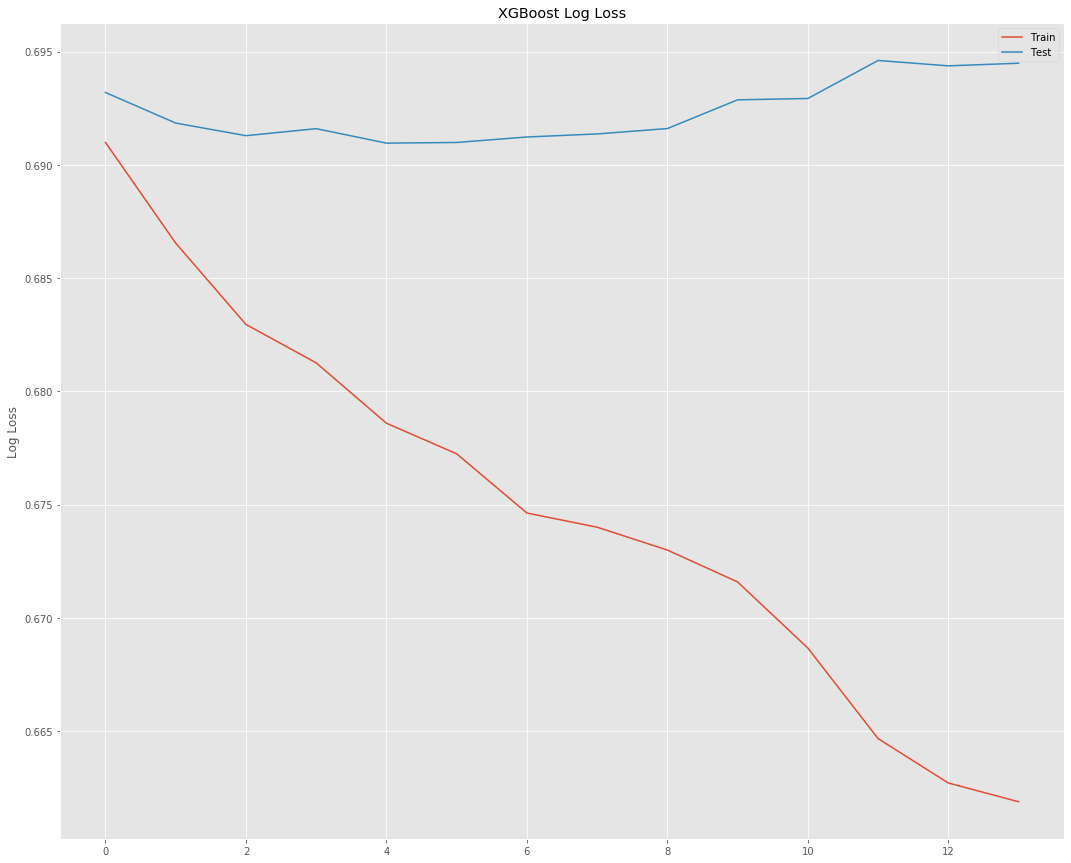

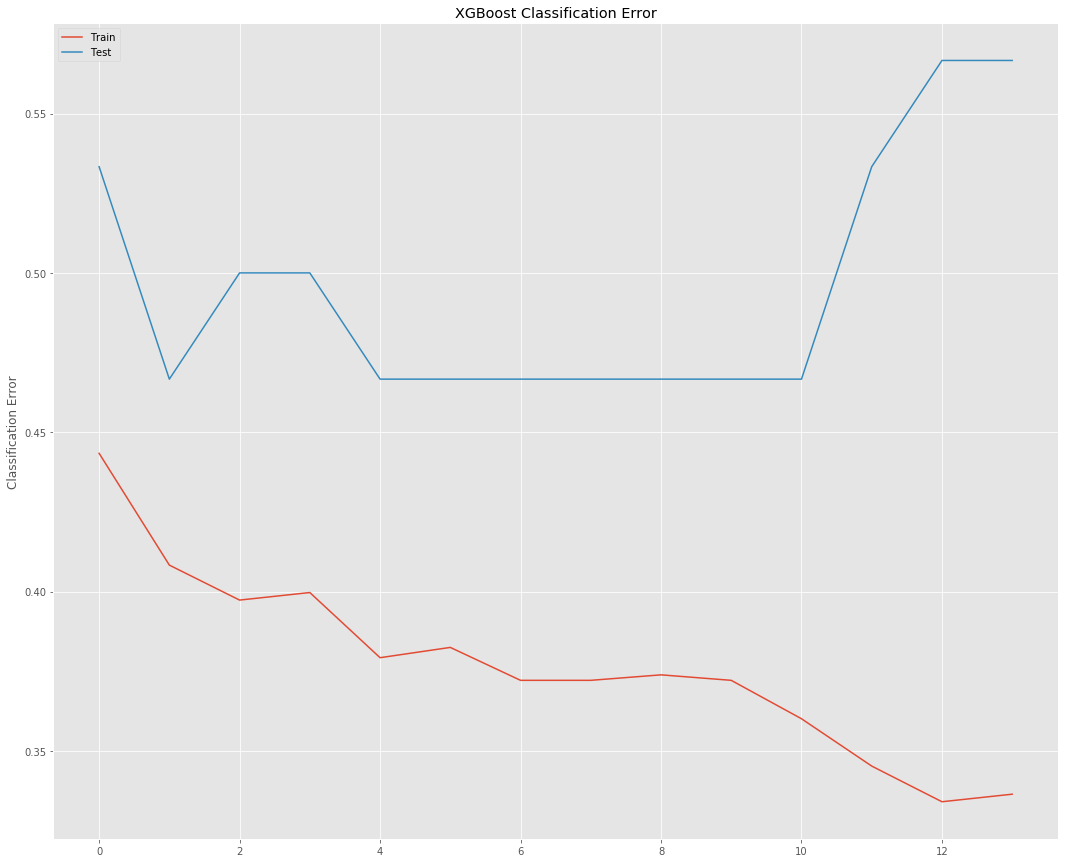

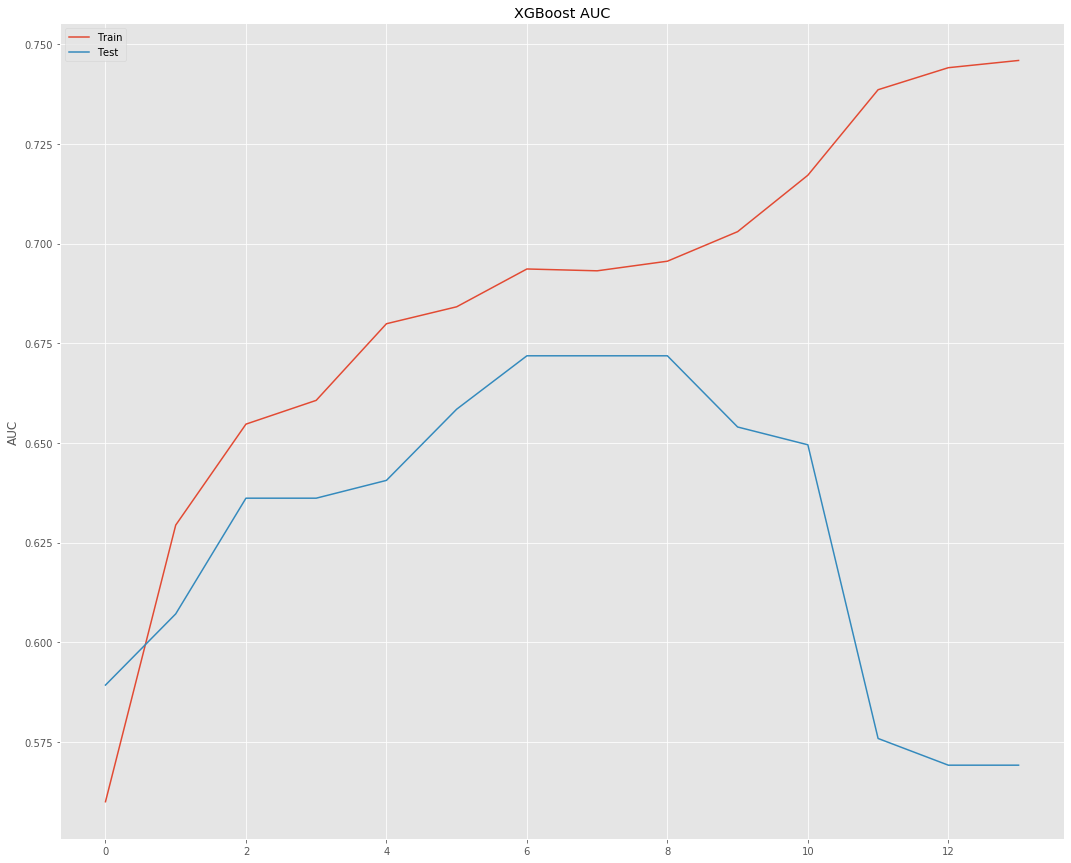

In [20]:
eval_set = [(X_train_thresh, y_train), (X_test_thresh, y_test)]

extra_model = XGBClassifier(**params)
extra_model.fit(
    X_train_thresh, 
    y_train, 
    early_stopping_rounds=10, 
    eval_metric=["auc", "error", "logloss"], 
    eval_set=eval_set,
    verbose=True
)

y_hat = extra_model.predict(X_test_thresh)

f1 = f1_score(y_pred=y_hat, y_true=y_test)
accuracy = accuracy_score(y_pred=y_hat, y_true=y_test)
baccuracy = balanced_accuracy_score(y_pred=y_hat, y_true=y_test)
lloss = log_loss(y_pred=y_hat, y_true=y_test)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("Balanced Accuracy: %.2f%%" % (baccuracy * 100.0))
print("F1 Score: %.2f%%" % (f1 * 100.0))
print("Log loss: %.2f" % lloss)

results = extra_model.evals_result()
epochs = len(results['validation_0']['error']) 
x_axis = range(0, epochs)

# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train') 
ax.plot(x_axis, results['validation_1']['logloss'], label='Test') 
ax.legend()

plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()

# plot classification error
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train') 
ax.plot(x_axis, results['validation_1']['error'], label='Test') 
ax.legend()

plt.ylabel('Classification Error') 
plt.title('XGBoost Classification Error') 
plt.show()

# plot AUC
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['auc'], label='Train') 
ax.plot(x_axis, results['validation_1']['auc'], label='Test') 
ax.legend()

plt.ylabel('AUC') 
plt.title('XGBoost AUC') 
plt.show()

In [21]:
# Mejor iteración
params['n_estimators'] = 5

eval_set = [(X_train_thresh, y_train)]

extra_model = XGBClassifier(**params)
extra_model.fit(
    X_train_thresh, 
    y_train, 
    eval_metric="error",
    eval_set=eval_set
)

[0]	validation_0-error:0.443392
[1]	validation_0-error:0.408308
[2]	validation_0-error:0.397331
[3]	validation_0-error:0.399699
[4]	validation_0-error:0.379251


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=0.5, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, n_estimators=5, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=5,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [22]:
results = cross_val_score(extra_model, X_train_thresh, y_train, cv=tscv)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Accuracy: 49.96% (8.63%)


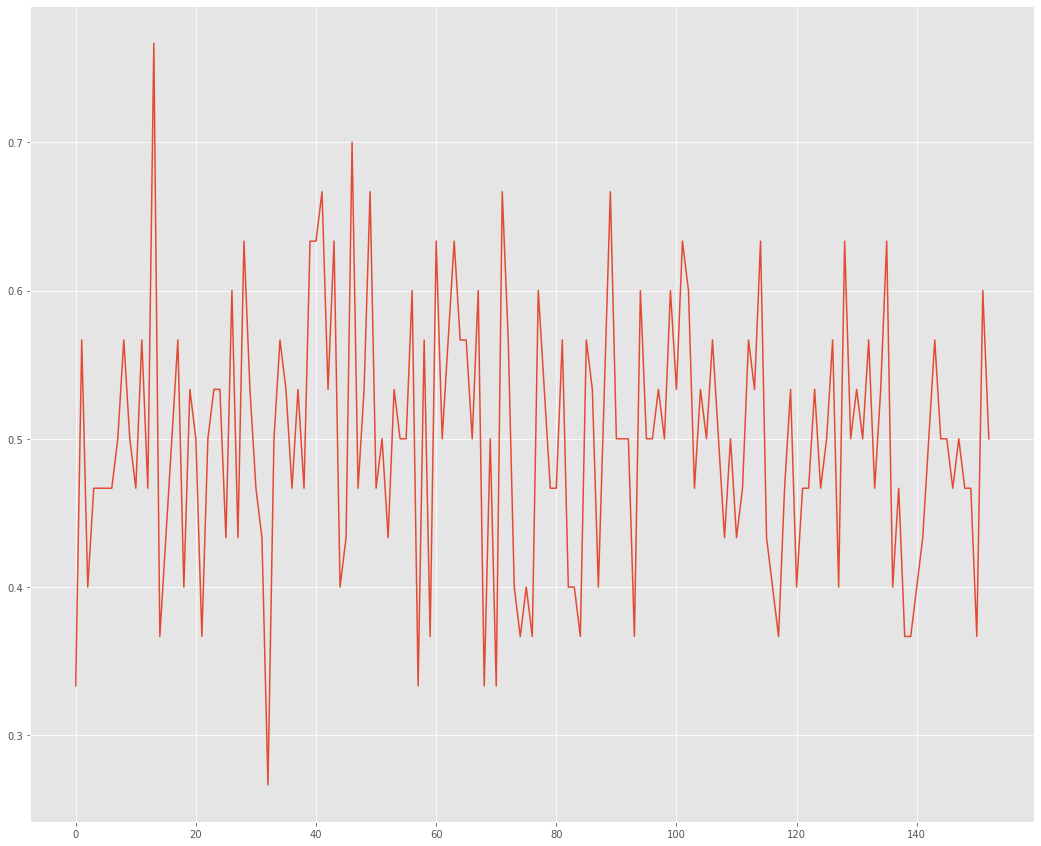

In [23]:
plt.plot(results)
plt.show()

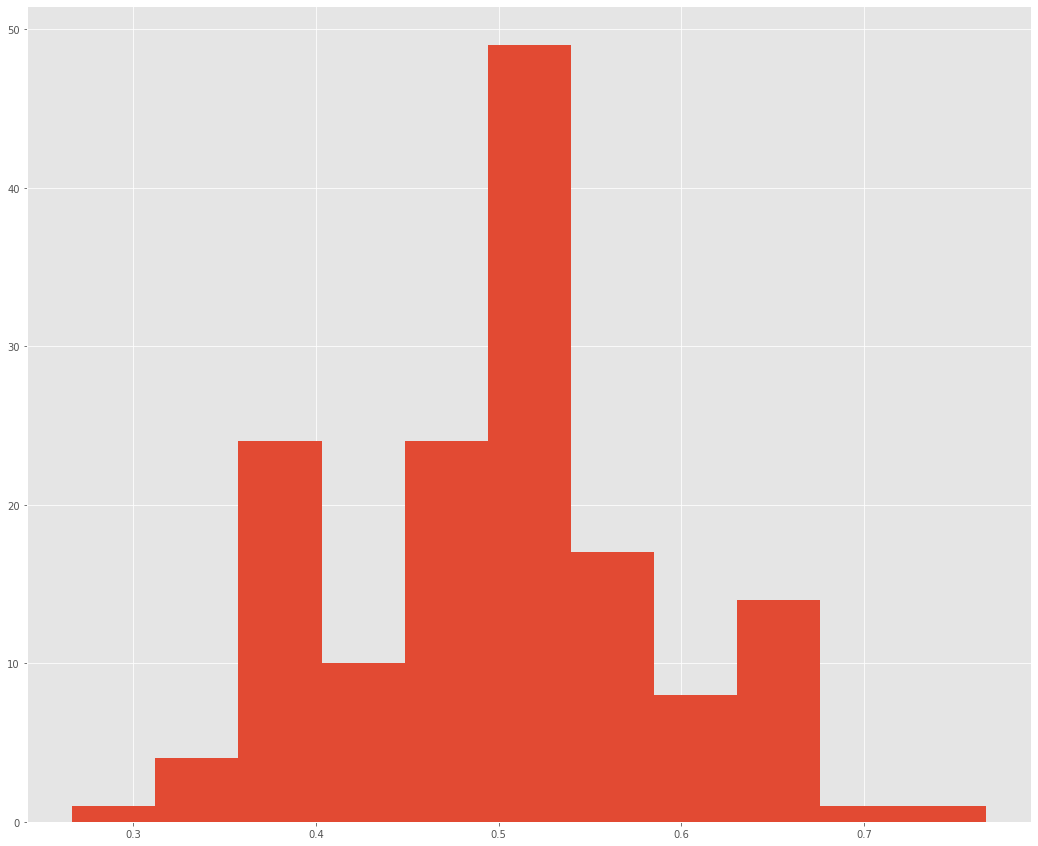

In [24]:
plt.hist(results, bins='auto')
plt.show()

In [25]:
confusion_matrix(y_pred=y_hat, y_true=y_test)

array([[ 2, 14],
       [ 0, 14]])

In [26]:
# Hold-out Dataset
ho = df[-30:]
featurizer_ho = Featurizer(ho)
featurizer_ho.add_features(forecast_horizon=30, with_ndays_lag=0)

X_ho, y_ho = featurizer_ho.train_split()
#X_ho = X_ho[-28:]
#y_ho = y_ho[-28:]

X_ho

,Open,High,Low,Close,Volume,Dividends,Stock Splits,week_day,month_day,month,...,low_pct_change,low_log_ret,volume_pct_change,volume_log_ret,closet1_opent_diff,closet1_opent_trend,close_trend,percent_b,bandwidth_b,percentb_signal
Date,,,,,,,,,,,,,,,,,,,,,
2019-11-27,9353.500000,9388.700195,9333.400391,9362.700195,135045800.0,0,0,2,27,11,...,0.004866,0.004855,-0.370964,-0.463567,28.700195,1,0,0.676777,9396.354983,0
2019-11-28,9353.599609,9373.099609,9343.799805,9359.000000,107163700.0,0,0,3,28,11,...,0.001114,0.001114,-0.206464,-0.231256,-9.100586,-1,-1,0.621636,9389.629225,0
2019-11-29,9334.500000,9404.500000,9312.500000,9352.000000,140835600.0,0,0,4,29,11,...,-0.003350,-0.003355,0.314210,0.273236,-24.500000,-1,-1,0.534652,9382.897841,0
2019-12-02,9367.200195,9390.900391,9146.599609,9156.299805,200666300.0,0,0,0,2,12,...,-0.017815,-0.017975,0.424827,0.354050,15.200195,1,-1,0.059231,9485.422490,0
2019-12-03,9176.799805,9209.799805,9110.099609,9135.700195,162636000.0,0,0,1,3,12,...,-0.003991,-0.003999,-0.189520,-0.210129,20.500000,1,-1,0.156146,9493.144520,0
2019-12-04,9146.200195,9277.599609,9144.799805,9270.799805,152240500.0,0,0,2,4,12,...,0.003809,0.003802,-0.063919,-0.066053,10.500000,1,0,0.475815,9473.251125,0
2019-12-05,9284.299805,9325.799805,9243.400391,9243.400391,120855300.0,0,0,3,5,12,...,0.010782,0.010724,-0.206155,-0.230868,13.500000,1,-1,0.411342,9456.130697,0
2019-12-06,9267.299805,9395.400391,9247.700195,9382.700195,125323400.0,0,0,4,6,12,...,0.000465,0.000465,0.036971,0.036304,23.899414,1,0,0.758440,9470.712817,0
2019-12-09,9378.200195,9403.500000,9354.599609,9354.599609,106942600.0,0,0,0,9,12,...,0.011560,0.011493,-0.146667,-0.158605,-4.500000,-1,-1,0.668921,9471.999950,0


In [27]:
# Hold out data set
X_ho_thresh = selection.transform(X_ho)
                               
y_ho_hat = extra_model.predict(X_ho_thresh)

f1 = f1_score(y_pred=y_ho_hat, y_true=y_ho)
accuracy = accuracy_score(y_pred=y_ho_hat, y_true=y_ho)
baccuracy = balanced_accuracy_score(y_pred=y_ho_hat, y_true=y_ho)
lloss = log_loss(y_pred=y_ho_hat, y_true=y_ho)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("Balanced Accuracy: %.2f%%" % (baccuracy * 100.0))
print("F1 Score: %.2f%%" % (f1 * 100.0))
print("Log loss: %.2f" % lloss)

Accuracy: 42.86%
Balanced Accuracy: 48.96%
F1 Score: 57.89%
Log loss: 19.74


In [28]:
confusion_matrix(y_pred=y_ho_hat, y_true=y_ho)

array([[ 1, 15],
       [ 1, 11]])

In [29]:
np.array(y_ho)

array([-1., -1., -1., -1.,  1., -1.,  1., -1., -1.,  1.,  1.,  1.,  1.,
       -1.,  1., -1.,  1., -1.,  1.,  1., -1., -1.,  1., -1., -1., -1.,
        1., -1.])

In [30]:
y_ho_hat

array([ 1.,  1.,  1.,  1.,  1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.])

In [31]:
down_trend = list(filter(lambda x: x == -1, y_test))
up_trend = list(filter(lambda x: x == 1, y_test))

print(f'Down trend => {len(down_trend)}')
print(f'Up trend => {len(up_trend)}')

Down trend => 16
Up trend => 14


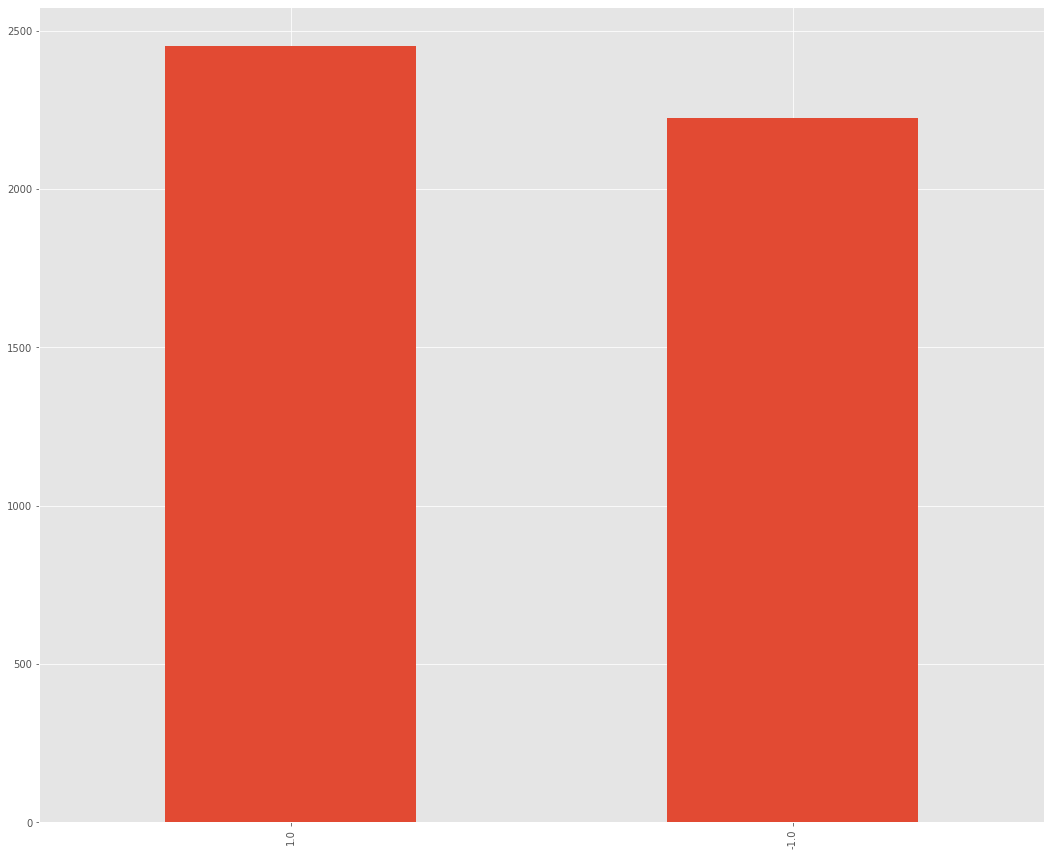

In [32]:
featurizer.df['PREDICTOR_1dayAhead'][:-1].value_counts().plot(kind="bar")

In [33]:
y_ho_prima = np.array(y_ho)

ok = 0
for i in range(0, y_ho_prima.shape[0]):
    if y_ho_prima[i] == y_ho_hat[i]:
        print('Ok')
        ok += 1
    else:
        print('NOk')
        
        
print(f'Acertados => {ok}')
print(f'Fallados => {y_ho_prima.shape[0] - ok}')


NOk
NOk
NOk
NOk
Ok
Ok
Ok
NOk
NOk
Ok
Ok
Ok
Ok
NOk
Ok
NOk
Ok
NOk
NOk
Ok
NOk
NOk
Ok
NOk
NOk
NOk
Ok
NOk
Acertados => 12
Fallados => 16


In [34]:
featurizer = Featurizer(df)
featurizer.add_features(forecast_horizon=5, with_ndays_lag=0)

X, y = featurizer.train_split()

X_final = selection.transform(X)

eval_set = [(X_final, y)]

final_model = XGBClassifier(**params)
final_model.fit(
    X_final, y,
    eval_metric=["error", "logloss", "auc"], 
    eval_set=eval_set
)

[0]	validation_0-error:0.446876	validation_0-logloss:0.690936	validation_0-auc:0.563
[1]	validation_0-error:0.41394	validation_0-logloss:0.687018	validation_0-auc:0.624346
[2]	validation_0-error:0.40289	validation_0-logloss:0.684119	validation_0-auc:0.642951
[3]	validation_0-error:0.403102	validation_0-logloss:0.682451	validation_0-auc:0.645371
[4]	validation_0-error:0.389928	validation_0-logloss:0.680024	validation_0-auc:0.669048


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=0.5, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, n_estimators=5, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=5,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [35]:
featurizer.unpredicted_data()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,week_day,month_day,month,...,low_pct_change,low_log_ret,volume_pct_change,volume_log_ret,closet1_opent_diff,closet1_opent_trend,close_trend,percent_b,bandwidth_b,percentb_signal
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-09,9629.200195,9644.799805,9574.599609,9581.799805,151793544.0,0,0,3,9,1,...,0.005704,0.005687,0.133146,0.124998,37.799805,1,-1,0.474995,9786.792646,0


In [36]:
X_thresh = selection.transform(featurizer.unpredicted_data())
                               
final_model.predict(X_thresh)

array([-1.])

In [78]:
from joblib import dump, load

dump(final_model, 'ibex35_20200106.model')
dump(selection, 'ibex35_20200106.sel')

['ibex35_20200106.sel']